# Домашняя работа Кривоносова Андрея (БЭК-211) по Математической статистике

In [50]:
import numpy as np
import pandas as pd
import random
from math import factorial
import scipy
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu, bartlett, ttest_ind, shapiro, ks_2samp, ttest_1samp, chi2_contingency, ttest_rel, t, norm, contingency
from itertools import product

random.seed(42)

# №1
Однажды в Самарканде турист заказывал Яндекс-такси. На десятом заказе впервые приехал таксист, который уже раньше приезжал к туристу. Для упрощения предположим, что все n таксистов Самарканда всегда на работе и приезжают равновероятно.


### А 
[5] Постройте график функции правдоподобия как функции от общего количества такси n. Найдите оценку числа n методом максимального правдоподобия.

Данное распределение очень похоже на геометрическое в вариации "число неудач до первого успеха", но есть одно НО: события являются зависимыми. Если к туристу приехал какой-либо таксист (Не важно какой, поэтому вероятность приезда верного $p_1=\frac{n}{n}=1$ на первом наблюдении), то вторым таксистом должен быть НЕ 1, т.е. $p_2=\frac{n-1}{n}$. Третьим таксистом должен быть не 1 и не 2, т.е. $p_3=\frac{n-2}{n}$ и т.д. Так до 10 таксиста не включительно. 10-ым таксистом должен быть один из предыдущих таксистов, т.е. $p_3=\frac{9}{n}$. Таким образом мы получили вероятности для всех таксистов. Запишем функцию правдоподибия:
$$
L(n) = \frac{n}{n} * \frac{n-1}{n} * \frac{n-2}{n}*...*\frac{n-8}{n}*\frac{9}{n} = \frac{9}{n^9} * \frac{(n-1)!}{(n-7)!} \to \max_{n}
$$

Построим график:

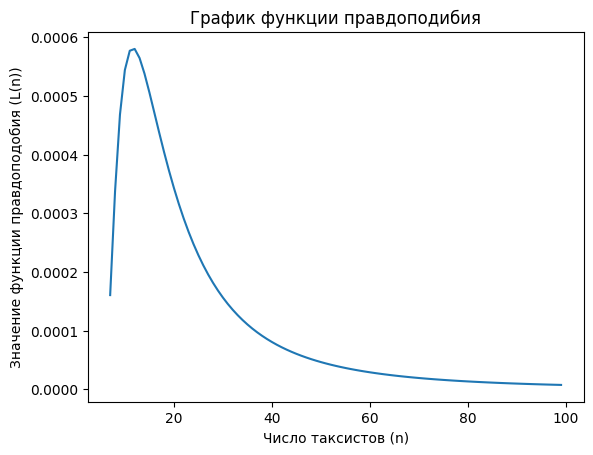

In [51]:
L_values = []

def L(n):
    return ((9 / n ** 9) * factorial(n - 1) / factorial(n - 7))

for n in range(7, 100):
  L_values.append(L(n))

# Строим линейный график
plt.plot(range(7, 100), L_values)

# Добавляем заголовок и подписи осей
plt.title('График функции правдоподибия')
plt.ylabel('Значение функции правдоподобия (L(n))')
plt.xlabel('Число таксистов (n)')

# Отображаем график
plt.show()

Визуально видно, что решение будет где-то в районе 11-15. Найдём решение:

In [52]:
N = np.arange(7, 100)
L_values = np.vectorize(L)(N)
N_ml = N[np.argmax(L_values)]
print(f"Оценка числа n методом максимального правдоподобия: {N_ml}")

Оценка числа n методом максимального правдоподобия: 12


Это целочисленное решение. Если мы запишем данную функцию в Wolfram, то получим n = 11.62. Но, кажется, 0.62 таксиста - это странно.

**Ответ:**
Целочисленный: $\overbrace{n_{ML}}$=12

Вещественный: $\overbrace{n_{ML}}$=11.62

### Б)  Постройте график математического ожидания номера заказа, на котором происходит первый повторный приезда, как функции от общего количества такси n. Найдите оценку числа n методом моментов.


Пользуясь ранее выведенной формулой вероятности для первого повторного приезда таксиста, ранее приезжавшего, на заказ номер X (В функции правдоподобия X=10) и обобщив её на все X мы получаем следующую функцию математического ожидания в зависимости от N:
$$
E(X|n) =  \sum_{x=2}^ {n+1} \frac{(n-1)!}{(n-x+1)!} * \frac{(x-1)}{n^{x-1}} * x
$$
Построим график:

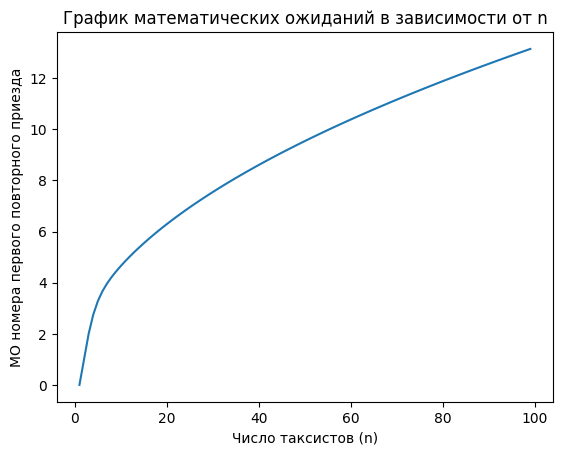

In [53]:
def E_n(n):
  E_x = 0
  for x in range(1, n+1):
    E_x+= x * (((x-1) / n ** (x-1)) * factorial(n - 1) / factorial(n - x + 1))
  return E_x
N = np.arange(1, 100)
E_n_values = np.vectorize(E_n)(N)

# Строим линейный график
plt.plot(N, E_n_values)

# Добавляем заголовок и подписи осей
plt.title('График математических ожиданий в зависимости от n')
plt.ylabel('МО номера первого повторного приезда')
plt.xlabel('Число таксистов (n)')

# Отображаем график
plt.show()

Найдём оценку методом моментов:
$$
E(X|n) =  \sum_{x=2}^ {n+1} \frac{(n-1)!}{(n-x+1)!} * \frac{(x-1)}{n^{x-1}} * x = 10
$$

In [54]:
x_obs = 10

N = np.arange(1, 100)
E_diffs = np.vectorize(lambda n: abs(E_n(n)-x_obs))(N)
N_mm = N[np.argmin(E_diffs)]
print(f"Оценка числа n методом максимального правдоподобия: {N_mm}")

Оценка числа n методом максимального правдоподобия: 55


Это целочисленное решение. К сожалению, вещественный ответ найти не представляется возможным, так как Wolfram умирает, а считать вручную = смерть исполнителя домашней работы. Поэтому, у сожалению, только целочисленный ответ. 

**Ответ:**
Целочисленный: $\overbrace{n_{MM}}$=55

### В) 
[15] Предположим, что настоящее n равно 100. Проведя 10000 симуляций вызовов такси до первого повторного, рассчитайте 10000 оценок методом моментов и 10000 оценок методом максимального правдоподобия. Постройте гистограммы для оценок двух методов. Оцените смещение, дисперсию и среднеквадратичную ошибку двух методов.

Проведём симуляции:

In [55]:
np.random.seed(42)
n = 100
n_obs = 10_000
MM_n = []
ML_n = []

def ML(exp: set):

    x = len(exp)

    def L_x(x, n):
      return (((x-1) / n ** (x-1)) * factorial(n - 1) / factorial(n - x + 1))
    
    N = np.arange(x, 170)
    L_values = np.zeros(170-x)

    for n in N:
      L_value = L_x(x, n)
      L_values[n-x] = L_value

    N_ml = N[np.argmax(L_values)]
    return N_ml

def MM(exp: set):

    x_obs = len(exp)

    def E_n(n):
      E_x = 0
      for x in range(1, n+1):
        E_x+= x * (((x-1) / n ** (x-1)) * factorial(n - 1) / factorial(n - x + 1))
      return E_x

    N = np.arange(1, 170)
    E_diffs = np.vectorize(lambda n: abs(E_n(n)-x_obs))(N)
    N_mm = N[np.argmin(E_diffs)]
    return N_mm


for i in tqdm(range(2, n_obs)):
  exp = set()
  while True: 
    driver = random.randint(1, n)
    if driver in exp:
      break
    else:
      exp.add(driver)
  MM_n.append(MM(exp))
  ML_n.append(ML(exp))
  pass

MM_n = np.array(MM_n)
ML_n = np.array(ML_n)

  0%|          | 0/9998 [00:00<?, ?it/s]<ipython-input-55-c4df701ed43c>:12: RuntimeWarning: divide by zero encountered in long_scalars
  return (((x-1) / n ** (x-1)) * factorial(n - 1) / factorial(n - x + 1))
100%|██████████| 9998/9998 [08:04<00:00, 20.65it/s]


Построим гистограммы распределений:

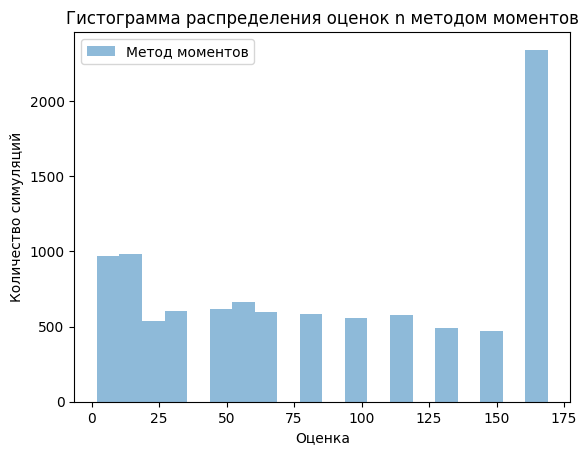

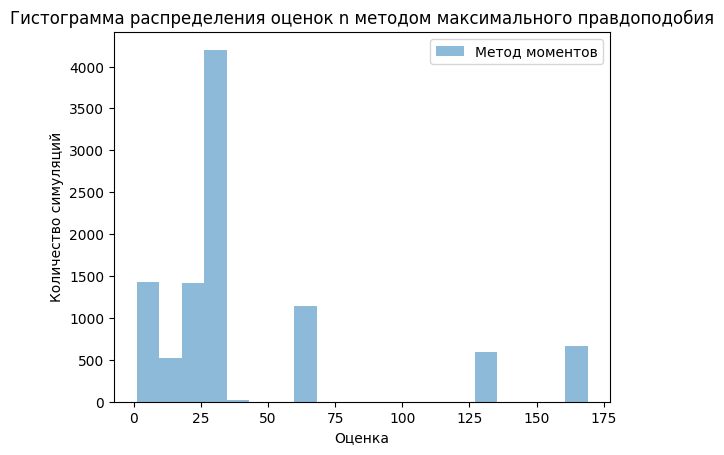

In [56]:
# Построение диаграммы рассеивания для метода моментов
plt.hist(MM_n, bins=20, alpha=0.5, label='Метод моментов')
plt.ylabel('Количество симуляций')
plt.xlabel('Оценка')
plt.title('Гистограмма распределения оценок n методом моментов')
plt.legend()
plt.show()

# Построение диаграммы рассеивания для метода максимального правдоподобия
plt.hist(ML_n, bins=20, alpha=0.5, label='Метод моментов')
plt.ylabel('Количество симуляций')
plt.xlabel('Оценка')
plt.title('Гистограмма распределения оценок n методом максимального правдоподобия')
plt.legend()
plt.show()

Оценим смещение, дисперсию и среднеквадратическую ошибку для обоих методов. 

In [57]:
MM_bias = np.mean(MM_n) - n
MM_variance = np.var(MM_n)
MM_mse = np.mean((MM_n - n)**2)

ML_bias = np.mean(ML_n) - n
ML_variance = np.var(ML_n)
ML_mse = np.mean((ML_n - n)**2)

print("Метод моментов:")
print("Смещение:", MM_bias)
print("Дисперсия:", MM_variance)
print("MSE:", MM_mse)
print("")
print("Метод максимального правдоподобия:")
print("Смещение:", ML_bias)
print("Дисперсия:", ML_variance)
print("MSE:", ML_mse)

Метод моментов:
Смещение: -14.390678135627127
Дисперсия: 3645.6213253853016
MSE: 3852.7129425885178

Метод максимального правдоподобия:
Смещение: -55.67353470694139
Дисперсия: 1899.1214660215496
MSE: 4998.663932786557


## №2

Однажды в Самарканде турист заказывал Яндекс-такси. На десятом заказе он обнаружил, что у таксистов было 6 разных имён. Для упрощения предположим, что все n имён среди таксистов встречаются равновероятно и независимо от поездки к поездке.

### А) 
[5] Постройте график функции правдоподобия как функции от общего количества имён n. Найдите оценку числа n методом максимального правдоподобия.

На первый взгляд, данное распределение очень похоже на биноминальное, где успехом является появление нового имени. Но также как в предыдущем случае есть одно большое НО: события зависимы. Если к туристу приехал какой-либо таксист с любым именем (Не важно каким, поэтому вероятность приезда верного $p_1=\frac{n}{n}=1$ на первом наблюдении), то вторым таксистом должен быть таксист не с именем первого, т.е. $p_2=\frac{n-1}{n}$. Третьим таксистом должен быть таксист не с именами первого и второго, т.е. $p_3=\frac{n-2}{n}$ и т.д. Так до 6 таксиста включительно. С 7 по 10 таксисты должны иметь имена предыдущих 6-ти, т.е. $p_{7-10}=\frac{6}{n}$. Но предыдущее рассуждение предполагает строгий порядок, в котором сначала приезжает 6 таксистов с разными именами, а после 4 таксиста с именами предыдущих. Чтобы устранить детерминированный порядок мы дожны добавить множитель, характеризующий перестановки повторящихся имён по отношению к уникальным. Т.е. приехал 1 человек, а после 4 повторяющихся или 4 повторяющихся в приехали в самом конце? Данный множитель достаточно сложно определить аналитически (у меня не получилось), но можно его запрограммировать (что я и сделал + оптимизировал). Таким образом, определив требуемые вроятности для всех имён и определив коэффициенты мы можем записать нашу функцию правдоподобия для случая, когда из 10 таксистов встретились 6 с разными именами.
$$
L(n) = С(6) *(\frac{n}{n} * \frac{n-1}{n} * \frac{n-2}{n}*...*\frac{n-5}{n})*(\frac{6}{n})^4 = С(6) * \frac{(n-1)!}{(n-6)!} * \frac{1}{n^9} * 6^4 *  \to \max_{n}
$$ 

Мы можем записать эту формулу в общем виде, где количество заказов равно 10, количество уникальных имён равно x, общее количество имён таксистов равно n: 
$$
L(n|x) = С(6) * \frac{(n-1)!}{(n-x)!} * \frac{1}{n^9} * x^{10-x} *  \to \max_{n}
$$
$$
s.to:
x<=10
$$ 

Функция подбора коэффициента. В коэффициенте также зашит множитель $x^{10-x}$.

In [58]:
def coef(x):
  count = 0
  unic = tuple(range(0, x))
  variants = product(unic, repeat=10)
  for comb in variants:
    if len(set(comb))==x:
      count+=1
  return count/factorial(x)

In [59]:
while True:
  print("Код для подбора коэффциентов работает ОЧЕНЬ долго. Хотите ли ВЫ ждать или воспользуетесь готовыми значениями?")
  answer = input("1 - Ждём. 0 - Готовые (Введите 0 или 1):")
  if answer in ["0", "1"]:
    break
if answer == "1":
  coefs = {1:coef(1),
         2:coef(2),
         3:coef(3),
         4:coef(4),
         5:coef(5),
         6:coef(6),
         7:coef(7),
         8:coef(8),
         9:coef(9),
         10:coef(10)}
else:
  coefs = {1:1,
          2:511,
          3:9330,
          4:34105,
          5:42525,
          6:22827,
          7:5880,
          8:750,
          9:45,
          10:1}
print(coefs)

Код для подбора коэффциентов работает ОЧЕНЬ долго. Хотите ли ВЫ ждать или воспользуетесь готовыми значениями?
1 - Ждём. 0 - Готовые (Введите 0 или 1):0
{1: 1, 2: 511, 3: 9330, 4: 34105, 5: 42525, 6: 22827, 7: 5880, 8: 750, 9: 45, 10: 1}


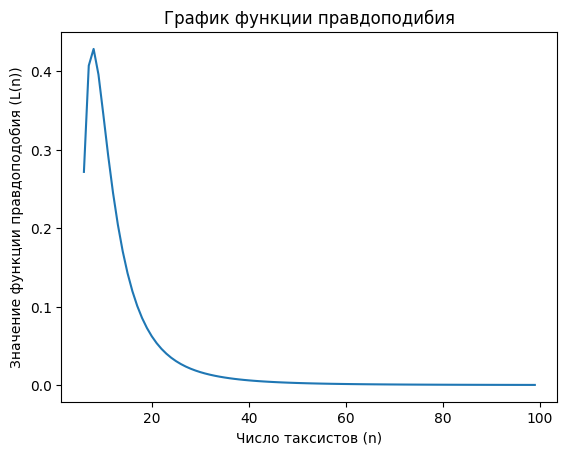

In [60]:
L_values = []

def L(n):
    return  coefs[6] * ((factorial(n - 1) / factorial(n - 6)) * (1 / n ** 9))

for n in range(6, 100):
  L_values.append(L(n))

# Строим линейный график
plt.plot(range(6, 100), L_values)

# Добавляем заголовок и подписи осей
plt.title('График функции правдоподибия')
plt.ylabel('Значение функции правдоподобия (L(n))')
plt.xlabel('Число таксистов (n)')

# Отображаем график
plt.show()

Визуально видно, что решение будет где-то в районе 6-10. Найдём решение:

In [61]:
N = np.arange(6, 100)
L_values = np.vectorize(L)(N)
N_ml = N[np.argmax(L_values)]
print(f"Оценка числа n методом максимального правдоподобия: {N_ml}")

Оценка числа n методом максимального правдоподобия: 8


Это целочисленное решение. Если мы запишем данную функцию в Wolfram, то получим n = 7.76. Но, кажется, 0.76 имени - это странно. Хотя может быть какое сокращение)

**Ответ:**
Целочисленный: $\overbrace{n_{ML}}$=8

Вещественный: $\overbrace{n_{ML}}$=7.76

### Б) 
[5] Постройте график математического ожидания числа разных имён у 10 таксистов, как функции от общего количества имён n. Найдите оценку числа n методом моментов.

Пользуясь ранее выведенной формулой вероятности получения X различных имён среди 10 вызванных таксистов (обобщение в прошлом пункте) мы получаем следующую функцию математического ожидания в зависимости от N:
$$
E(X|n) =  \sum_{x=1}^ {10}  C(x) * \frac{(n-1)!}{(n-x)!} * \frac{1}{n^9} * x^{10-x} * x
$$
Построим график:

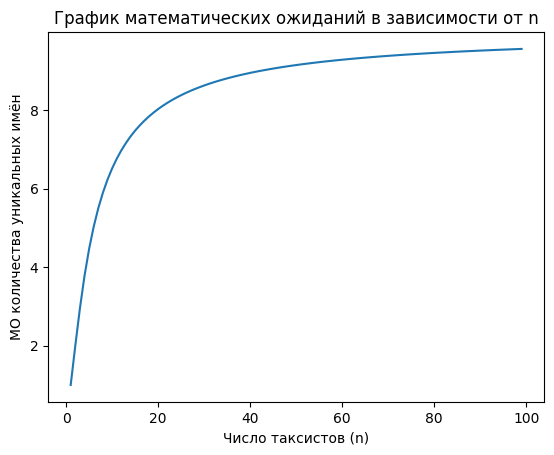

In [62]:
def E_n(n):
  E_x = 0
  for x in range(1, 11):
    try:
      E_x+= coefs[x] * x * ((factorial(n - 1) / factorial(n - x)) * (1 / n ** 9))
    except:
      E_x+=0
  return E_x

N = np.arange(1, 100)
E_n_values = np.vectorize(E_n)(N)

# Строим линейный график
plt.plot(N, E_n_values)

# Добавляем заголовок и подписи осей
plt.title('График математических ожиданий в зависимости от n')
plt.ylabel('МО количества уникальных имён')
plt.xlabel('Число таксистов (n)')

# Отображаем график
plt.show()

Найдём оценку методом моментов:
$$
E(X|n) =  \sum_{x=1}^ {10}  C_{10}^x * \frac{(n-1)!}{(n-x)!} * \frac{1}{n^9} * x^{10-x} * x = 6
$$

In [63]:
x_obs = 6
N = np.arange(1, 100)
N_mm = N[np.argmin(abs(E_n_values-x_obs))]
print(f"Оценка числа n методом максимального правдоподобия: {N_mm}")

Оценка числа n методом максимального правдоподобия: 8


Это целочисленное решение. К сожалению, вещественный ответ найти не представляется возможным, так как Wolfram умирает, а считать вручную = смерть исполнителя домашней работы. Поэтому, к сожалению, только целочисленный ответ. 

**Ответ:**
Целочисленный: $\overbrace{n_{MM}}$=8

### В)

[15] Предположим, что настоящее n равно 20. Проведя 10000 симуляций десяти вызовов такси, рассчитайте 10000 оценок методом моментов и 10000 оценок методом максимального правдоподобия. Постройте гистограммы для оценок двух методов. Оцените смещение,дисперсию и среднеквадратичную ошибку двух методов.
Update 2023-06-07: если по выборке в симуляциях оценка метода моментов или метода максимального правдоподобия стремится к бесконечности, то можно ограничить её сверху большим числом, например, 100.

Проведём симуляции:

In [64]:
np.random.seed(50)
n = 20
n_obs = 10_000
MM_n = []
ML_n = []

def ML(exp: set):
    x = len(exp)

    def L_x(x, n):
      try:
        return  coefs[x] * ((factorial(n - 1) / factorial(n - x)) * (1 / n ** 9))
      except:
        return -100
    
    N = np.arange(1, 101)
    L_values = np.zeros(len(N))

    for n in N:
      L_value = L_x(x, n)
      L_values[n-1] = L_value
    
    N_ml = N[np.argmax(L_values)]
    return N_ml

def MM(exp: set):

    x_obs = len(exp)

    def E_n(n):
      E_x = 0
      for x in range(1, 11):
        try:
          E_x+= coefs[x] * x * ((factorial(n - 1) / factorial(n - x)) * (1 / n ** 9))
        except:
          E_x+=0
      return E_x

    N = np.arange(1, 101)
    N_mm = N[np.argmin(abs(E_n_values-x_obs))]
    return N_mm


experiments = np.zeros(n_obs)
for i in tqdm(range(0, n_obs)):
  exp = set()
  for i in range(10): 
    driver = random.randint(0, n)
    exp.add(driver)
  MM_n.append(MM(exp))
  ML_n.append(ML(exp))
  pass

MM_n = np.array(MM_n)
ML_n = np.array(ML_n)

100%|██████████| 10000/10000 [00:04<00:00, 2322.30it/s]


Построим гистограммы распределений:

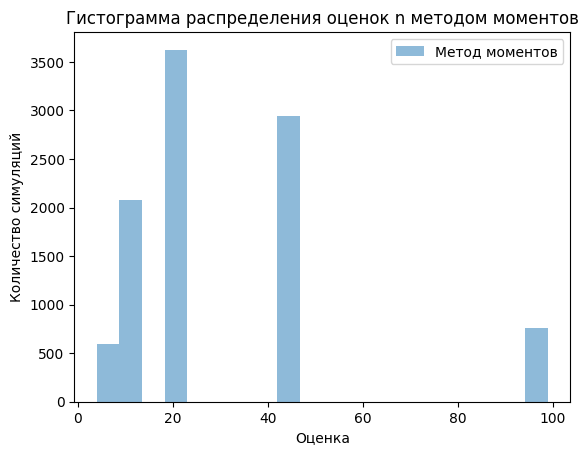

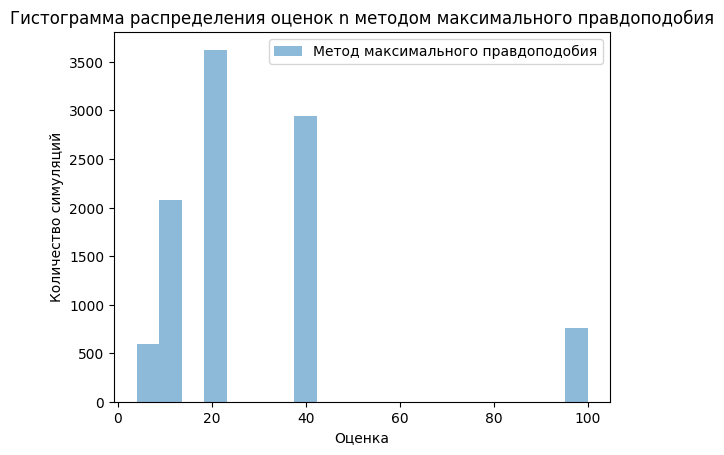

In [65]:
# Построение диаграммы рассеивания для метода моментов
plt.hist(MM_n, bins=20, alpha=0.5, label='Метод моментов')
plt.ylabel('Количество симуляций')
plt.xlabel('Оценка')
plt.title('Гистограмма распределения оценок n методом моментов')
plt.legend()
plt.show()

# Построение диаграммы рассеивания для метода максимального правдоподобия
plt.hist(ML_n, bins=20, alpha=0.5, label='Метод максимального правдоподобия')
plt.ylabel('Количество симуляций')
plt.xlabel('Оценка')
plt.title('Гистограмма распределения оценок n методом максимального правдоподобия')
plt.legend()
plt.show()

Оценим смещение, дисперсию и среднеквадратическую ошибку для обоих методов. 

In [66]:
moment_bias = np.mean(MM_n) - n
moment_variance = np.var(MM_n)
moment_mse = np.mean((MM_n - n)**2)

likelihood_bias = np.mean(ML_n) - n
likelihood_variance = np.var(ML_n)
likelihood_mse = np.mean((ML_n - n)**2)

print("Метод моментов:")
print("Смещение:", MM_bias)
print("Дисперсия:", MM_variance)
print("MSE:", MM_mse)
print("")
print("Метод максимального правдоподобия:")
print("Смещение:", ML_bias)
print("Дисперсия:", ML_variance)
print("MSE:", ML_mse)

Метод моментов:
Смещение: -14.390678135627127
Дисперсия: 3645.6213253853016
MSE: 3852.7129425885178

Метод максимального правдоподобия:
Смещение: -55.67353470694139
Дисперсия: 1899.1214660215496
MSE: 4998.663932786557


## №3
Иноагент Иннокентий по 20 наблюдениям строит 95%-й доверительный интервал для математического ожидания несколькими способами: классический асимптотический нормальный интервал, с помощью наивного бутстрэпа, с помощью бутстрэпа t-статистики.

### А)
[15] Для каждого способа с помощью 10000 симуляций оцените вероятность того, что номинально 95%-й доверительный интервал фактически накрывает математическое ожидание, если наблюдения распределены экспоненциально с интенсивностью 1.

In [67]:
np.random.seed(42)
sample_size = 20
simulations = 10000
true_mean = 1

# Классический асимптотический нормальный интервал
classic_normal_coverages = []
for _ in range(simulations):
    samples = np.random.exponential(scale=1, size=sample_size)
    sample_mean = np.mean(samples)
    sample_std = np.std(samples, ddof=1)
    z = norm.ppf(0.975)
    lower = sample_mean - z * sample_std / np.sqrt(sample_size)
    upper = sample_mean + z * sample_std / np.sqrt(sample_size)
    coverage = (lower <= true_mean <= upper)
    classic_normal_coverages.append(coverage)

# Наивный бутстрэп
naive_bootstrap_coverages = []
for _ in range(simulations):
    samples = np.random.exponential(scale=1, size=sample_size)
    bootstrap_samples = np.random.choice(samples, size=(simulations, sample_size), replace=True)
    bootstrap_mean = bootstrap_samples.mean(axis = 1)
    lower, upper = np.percentile(bootstrap_mean, [2.5, 97.5])
    coverage = (lower <= true_mean <= upper)
    naive_bootstrap_coverages.append(coverage)

# Бутстрэп t-статистики
t_bootstrap_coverages = []
for _ in range(simulations):
    samples = np.random.exponential(scale=1, size=sample_size)
    bootstrap_samples = np.random.choice(samples, size=(simulations, sample_size), replace=True)
    bootstrap_mean = bootstrap_samples.mean(axis = 1)
    t_statistic = (bootstrap_mean - samples.mean()) / (np.std(bootstrap_samples, ddof=1, axis = 1) / np.sqrt(sample_size))
    lower = samples.mean() - np.percentile(t_statistic, 97.5)*(np.std(samples, ddof=1) / np.sqrt(sample_size))
    upper = samples.mean() - np.percentile(t_statistic, 2.5)*(np.std(samples, ddof=1) / np.sqrt(sample_size))
    coverage = (lower <= true_mean <= upper)
    t_bootstrap_coverages.append(coverage)

# Вычисление вероятностей накрытия
classic_normal_coverage_prob = np.mean(classic_normal_coverages)
naive_bootstrap_coverage_prob = np.mean(naive_bootstrap_coverages)
t_bootstrap_coverage_prob = np.mean(t_bootstrap_coverages)

# Вывод результатов
print("Классический ассимптотический интервал:")
print("Вероятность накрытия:", classic_normal_coverage_prob)

print("Наивный бутстрэп:")
print("Вероятность накрытия:", naive_bootstrap_coverage_prob)

print("Бутстрэп t-статистики:")
print("Вероятность накрытия:", t_bootstrap_coverage_prob)


Классический ассимптотический интервал:
Вероятность накрытия: 0.9036
Наивный бутстрэп:
Вероятность накрытия: 0.9018
Бутстрэп t-статистики:
Вероятность накрытия: 0.9494


### Б)
[5] Пересчитайте вероятности накрытия, если наблюдения имеют распределение Стьюдента с тремя степенями свободы.

In [68]:
from scipy.stats import norm, t

np.random.seed(42)
sample_size = 20
simulations = 10000
true_mean = 1

# Классический асимптотический нормальный интервал
classic_normal_coverages = []
for _ in range(simulations):
    samples = np.random.standard_t(df=3, size=sample_size)
    sample_mean = np.mean(samples)
    sample_std = np.std(samples, ddof=1)
    z = norm.ppf(0.975)
    lower = sample_mean - z * sample_std / np.sqrt(sample_size)
    upper = sample_mean + z * sample_std / np.sqrt(sample_size)
    coverage = (lower <= 0 <= upper)
    classic_normal_coverages.append(coverage)

# Наивный бутстрэп
naive_bootstrap_coverages = []
for _ in range(simulations):
    samples = np.random.standard_t(df=3, size=sample_size)
    bootstrap_samples = np.random.choice(samples, size=(simulations, sample_size), replace=True)
    bootstrap_mean = np.mean(bootstrap_samples, axis = 1)
    lower, upper = np.percentile(bootstrap_mean, [2.5, 97.5])
    coverage = (lower <= 0 <= upper)
    naive_bootstrap_coverages.append(coverage)

# Бутстрэп t-статистики
t_bootstrap_coverages = []
for _ in range(simulations):
    samples = np.random.standard_t(df=3, size=sample_size)
    bootstrap_samples = np.random.choice(samples, size=(simulations, sample_size), replace=True)
    bootstrap_mean = bootstrap_samples.mean(axis = 1)
    t_statistic = (bootstrap_mean - samples.mean()) / (np.std(bootstrap_samples, ddof=1, axis = 1) / np.sqrt(sample_size))
    lower = samples.mean() - np.percentile(t_statistic, 97.5)*(np.std(samples, ddof=1) / np.sqrt(sample_size))
    upper = samples.mean() - np.percentile(t_statistic, 2.5)*(np.std(samples, ddof=1) / np.sqrt(sample_size))
    coverage = (lower <= 0 <= upper)
    t_bootstrap_coverages.append(coverage)

# Вычисление вероятностей накрытия
classic_normal_coverage_prob = np.mean(classic_normal_coverages)
naive_bootstrap_coverage_prob = np.mean(naive_bootstrap_coverages)
t_bootstrap_coverage_prob = np.mean(t_bootstrap_coverages)

# Вывод результатов
print("Классический ассимптотический интервал:")
print("Вероятность накрытия:", classic_normal_coverage_prob)

print("Наивный бутстрэп:")
print("Вероятность накрытия:", naive_bootstrap_coverage_prob)

print("Бутстрэп t-статистики:")
print("Вероятность накрытия:", t_bootstrap_coverage_prob)


Классический ассимптотический интервал:
Вероятность накрытия: 0.9438
Наивный бутстрэп:
Вероятность накрытия: 0.9194
Бутстрэп t-статистики:
Вероятность накрытия: 0.9235


## в
В случае экспоненциального распределения лучший результат показал Бутстрэп t-статистики, в то время как в случе t-распределения лучший результат у  классического ассимптотического бутстрэпа. Это звучит несколько парадоксально, но так оно и есть. Лишь одно постоянно -  Naive Bootstarp. И это не странно, ведь Наивному Бутсрэпу вообще не важно, какое распределение. Он не использует никакие статистики, соответсвенно, нет никаких предпосылок и ограничений.

___________

In [69]:
data = pd.read_csv('22-23_hse_probability - Exam.csv')
data = data[['Last name', 'Unnamed: 72']]
data.columns = ['Last name', 'Экзамен']
data.dropna(inplace = True)
data.head()

,Last name,Экзамен
5,Репенкова,16.0
6,Ролдугина,0.0
7,Сафина,19.0
8,Сидоров,26.0
9,Солоухин,21.0


In [70]:
vowel_data = data[data['Last name'].apply(lambda x: x.strip().upper()[0] in "УЕЁЫАОЭЯИЮ")][['Last name', "Экзамен"]]
consonant_data = data[~data['Last name'].apply(lambda x: x.strip().upper()[0] in "УЕЁЫАОЭЯИЮ")][['Last name', "Экзамен"]]

vowel_data.reset_index(drop=True, inplace = True)
display(vowel_data.head())

consonant_data.reset_index(drop=True, inplace = True)
display(consonant_data.head())

,Last name,Экзамен
0,Адилхан,25.0
1,Алексанян,26.0
2,Охотин,25.0
3,Аврамчук,29.0
4,Авсеенко,26.0


,Last name,Экзамен
0,Репенкова,16.0
1,Ролдугина,0.0
2,Сафина,19.0
3,Сидоров,26.0
4,Солоухин,21.0


In [71]:
group_vowel, group_consonant = vowel_data["Экзамен"], consonant_data["Экзамен"]

**Дисклеймер:** я намеренно не удаляю те наблюдения, в которых за экзамен стоит 0 или неявка. В моём понимании, если не явился на экзамен, значит, написал его на 0. 

## №4

### A) 
[5] Используйте тест Уэлча.

Для проведения теста Уэлча, мы можем использовать функцию ttest_ind из библиотеки scipy.stats и указать аргумент equal_var=False, чтобы учесть возможное неравенство дисперсий между двумя группами.

In [72]:
t_statistic, p_value = ttest_ind(group_vowel, group_consonant, equal_var=False)

print("Тест Уэлча:")
print("P-value:", p_value)

if p_value < 0.05:
    print("Нулевая гипотеза отвергается")
else:
    print("Нулевая гипотеза НЕ отвергается")

Тест Уэлча:
P-value: 0.3974027153843839
Нулевая гипотеза НЕ отвергается


Можно повторить результат, проведя всё своими руками:

In [73]:
mean_vowel = np.mean(group_vowel)
mean_consonant = np.mean(group_consonant)

var_vowel = np.var(group_vowel, ddof=1)  # ddof=1 для несмещенной оценки дисперсии
var_consonant = np.var(group_consonant, ddof=1)

n_vowel = len(group_vowel)
n_consonant = len(group_consonant)

t_statistic = (mean_vowel - mean_consonant) / np.sqrt(var_vowel / n_vowel + var_consonant / n_consonant)

df = (var_vowel / n_vowel + var_consonant / n_consonant) ** 2 / (
    (var_vowel ** 2 / (n_vowel ** 2 * (n_vowel - 1))) + (var_consonant ** 2 / (n_consonant ** 2 * (n_consonant - 1)))
    )

alpha = 0.05
critical_t = t.ppf(1 - alpha / 2, df)

if np.abs(t_statistic) > critical_t:
    print("Нулевая гипотеза отвергается")
else:
    print("Нулевая гипотеза НЕ отвергается")

Нулевая гипотеза НЕ отвергается


### Б)

[5] Используйте наивный бутстрэп.

In [74]:
obs_diff = np.mean(group_vowel) - np.mean(group_consonant)
np.random.seed(42)

bootstrap_diffs = []
for _ in range(10000):
    bootstrap_vowel = np.random.choice(group_vowel, size=len(group_vowel), replace=True)
    bootstrap_consonant = np.random.choice(group_consonant, size=len(group_consonant), replace=True)
    bootstrap_diff = np.mean(bootstrap_vowel) - np.mean(bootstrap_consonant)
    bootstrap_diffs.append(bootstrap_diff)

lower, upper = np.percentile(bootstrap_diffs, [2.5, 97.5])
coverage = (lower <= 0 <= upper)

p_value = (np.abs(bootstrap_diffs) >= np.abs(obs_diff)).mean()

print("Наивный Бутстрэп:")
print("CI:", (lower, upper))
print("P-value:", p_value)

if coverage == True:
    print("0 (Нулевая гипотеза) накрывается доверительным интервалом")
else:
    print("0 (Нулевая гипотеза) НЕ накрывается доверительным интервалом")

if p_value < 0.05:
    print("Нулевая гипотеза отвергается")
else:
    print("Нулевая гипотеза НЕ отвергается")

Наивный Бутстрэп:
CI: (-3.6364516477969278, 1.3978834643398004)
P-value: 0.5418
0 (Нулевая гипотеза) накрывается доверительным интервалом
Нулевая гипотеза НЕ отвергается


### В)
[5] Используйте бутстрэп t-статистики.

In [75]:
obs_diff_t = ((np.mean(group_consonant) - np.mean(group_vowel)) - 0) / np.sqrt(group_consonant.var(ddof = 1) / len(group_consonant) + group_vowel.var(ddof = 1) / len(group_vowel))

np.random.seed(42)

bootstrap_diffs_t = []

for _ in range(10000):
    bootstrap_vowel = np.random.choice(group_vowel, size=len(group_vowel), replace=True)
    bootstrap_consonant = np.random.choice(group_consonant, size=len(group_consonant), replace=True)
    bootstrap_diff_t = ((np.mean(bootstrap_vowel) - np.mean(bootstrap_consonant)) - (np.mean(group_consonant) - np.mean(group_vowel))) / np.sqrt(bootstrap_consonant.var(ddof = 1) / len(bootstrap_consonant) + bootstrap_vowel.var(ddof = 1) / len(bootstrap_vowel)) 
    bootstrap_diffs_t.append(bootstrap_diff_t)

bootstrap_diffs_t = np.array(bootstrap_diffs_t)

upper = np.percentile(bootstrap_diffs_t, 97.5)
lower = np.percentile(bootstrap_diffs_t, 2.5)
coverage = (lower <= 0 <= upper)

p_value = (np.abs(bootstrap_diffs_t) >= np.abs(obs_diff_t)).mean()

print("Бутстрэп t-статистики:")
print("CI:", (lower, upper))
print("P-value:", p_value)

if coverage == True:
    print("0 (Нулевая гипотеза) накрывается доверительным интервалом")
else:
    print("0 (Нулевая гипотеза) НЕ накрывается доверительным интервалом")

if p_value < 0.05:
    print("Нулевая гипотеза отвергается")
else:
    print("Нулевая гипотеза НЕ отвергается")

Бутстрэп t-статистики:
CI: (-3.651607792831375, 0.2727854670937525)
P-value: 0.8155
0 (Нулевая гипотеза) накрывается доверительным интервалом
Нулевая гипотеза НЕ отвергается


### Г)

 [5] Используйте перестановочный тест.


In [76]:
np.random.seed(42)

obs_diff = np.mean(group_vowel) - np.mean(group_consonant)

combined = np.concatenate((group_vowel, group_consonant))
perm_diffs = []
for _ in range(10000):
    np.random.shuffle(combined)
    perm_vowel = combined[:len(group_vowel)]
    perm_consonant = combined[len(group_vowel):]
    perm_diff = np.mean(perm_vowel) - np.mean(perm_consonant)
    perm_diffs.append(perm_diff)

upper = np.percentile(perm_diffs, 97.5)
lower = np.percentile(perm_diffs, 2.5)
coverage = (lower <= 0 <= upper)

p_value = (np.abs(perm_diffs) >= np.abs(obs_diff)).mean()

print("Перестановочный тест:")
print("CI:", (lower, upper))
print("P-value:", p_value)

if coverage == True:
    print("0 (Нулевая гипотеза) накрывается доверительным интервалом")
else:
    print("0 (Нулевая гипотеза) НЕ накрывается доверительным интервалом")

if p_value < 0.05:
    print("Нулевая гипотеза отвергается")
else:
    print("Нулевая гипотеза НЕ отвергается")

Перестановочный тест:
CI: (-2.418980312973247, 2.321482656666907)
P-value: 0.3794
0 (Нулевая гипотеза) накрывается доверительным интервалом
Нулевая гипотеза НЕ отвергается


## №5

Составьте таблицу сопряжённости, поделив студентов писавших экзамен на четыре группы по двум признакам: набрал ли больше медианы или нет, на согласную или гласную букву начинается фамилия.

In [77]:
# Определяем медиану
median = np.median(np.concatenate((group_vowel, group_consonant)))

# Объединим таблицы, чтобы была общая таблица согласных и несогласных
vowel_data["V/C"] = 0
consonant_data["V/C"] = 1
union = pd.concat([vowel_data, consonant_data], ignore_index=True)

#Добавим признак "Больше медианы"
union["above_median"] = union['Экзамен'] > median
union

,Last name,Экзамен,V/C,above_median
0,Адилхан,25.0,0,True
1,Алексанян,26.0,0,True
2,Охотин,25.0,0,True
3,Аврамчук,29.0,0,True
4,Авсеенко,26.0,0,True
...,...,...,...,...
327,Савенкова,4.0,1,False
328,Сенников,19.0,1,True
329,Ся,0.0,1,False
330,Сятова,0.0,1,False


In [78]:
cont_table = pd.crosstab(union['above_median'], union['V/C'])
cont_table

V/C,0,1
above_median,,
False,28,138
True,21,145


### A)

[5] Постройте 95% асимптотический интервал для отношения шансов хорошо написать экзамен («несогласных» к «согласным»). Проверьте гипотезу о том, что отношение шансов
равно 1 и укажите P-значение.

In [79]:
#Используем https://en.wikipedia.org/wiki/Odds_ratio

# Вычисление отношения шансов
odds_ratio = (cont_table.loc[True, 1] * cont_table.loc[False, 0]) / (cont_table.loc[False, 1] * cont_table.loc[True, 0])

# Вычисление оценки логарифма отношения шансов и стандартного отклонения
log_odds_ratio = np.log(odds_ratio)
se_log_odds_ratio = np.sqrt(1 / cont_table.loc[True, 1] + 1 / cont_table.loc[False, 1] + 1 / cont_table.loc[True, 0] + 1 / cont_table.loc[False, 0])

# Вычисление асимптотического интервала
z_score = 1.96  # Z-значение для 95% доверительного интервала
lower_limit = np.exp(log_odds_ratio - z_score * se_log_odds_ratio)
upper_limit = np.exp(log_odds_ratio + z_score * se_log_odds_ratio)

# Проверка гипотезы о равенстве отношения шансов 1
null_hypothesis = 1.0
z_statistic = (log_odds_ratio - np.log(null_hypothesis)) / se_log_odds_ratio
p_value = 2 * (1 - norm.cdf(z_statistic))

coverage = (lower_limit <= z_statistic <= upper_limit)
p_value = (np.abs(perm_diffs) >= np.abs(obs_diff)).mean()

print("Перестановочный тест:")
print("95% асимптотический интервал:", (lower_limit, upper_limit))
print("z-статистика:", z_statistic)
print("P-value:", p_value)

if coverage == True:
    print("0 (Нулевая гипотеза) накрывается доверительным интервалом")
else:
    print("0 (Нулевая гипотеза) НЕ накрывается доверительным интервалом")

if p_value < 0.05:
    print("Нулевая гипотеза отвергается")
else:
    print("Нулевая гипотеза НЕ отвергается")

Перестановочный тест:
95% асимптотический интервал: (0.7597444386480954, 2.5833769194978795)
z-статистика: 1.0799144576000155
P-value: 0.3794
0 (Нулевая гипотеза) накрывается доверительным интервалом
Нулевая гипотеза НЕ отвергается


### Б)  
[5] Постройте 95% асимптотический интервал для отношения вероятностей хорошо написать экзамен. Проверьте гипотезу о том, что отношение вероятностей равно 1 и укажите
P-значение.

In [80]:
# Исполльзуем https://en.wikipedia.org/wiki/Relative_risk

RR = (cont_table.loc[True, 1]/(cont_table.loc[False, 1]+cont_table.loc[True, 1])) / (cont_table.loc[True, 0]/(cont_table.loc[False, 0]+cont_table.loc[True, 0]))
log_RR_ratio = np.log(RR)
SE_log_RR_ratio = (cont_table.loc[False, 0]/(cont_table.loc[True, 0]*(cont_table.loc[True, 0]+cont_table.loc[False, 0])) + cont_table.loc[False, 1]/(cont_table.loc[True, 1]*(cont_table.loc[True, 1]+cont_table.loc[False, 1])))**(0.5) 

# Вычисление асимптотического интервала
z_score = 1.96  # Z-значение для 95% доверительного интервала
lower_limit = np.exp(log_RR_ratio - SE_log_RR_ratio * z_score)
upper_limit = np.exp(log_RR_ratio + SE_log_RR_ratio * z_score)

# Проверка гипотезы о равенстве отношения вероятностей 1
null_hypothesis = 1.0
z_statistic = (log_RR_ratio - np.log(null_hypothesis)) / SE_log_RR_ratio
p_value = 2 * (1 - norm.cdf(abs(z_statistic)))

coverage = (lower_limit <= z_statistic <= upper_limit)
p_value = (np.abs(perm_diffs) >= np.abs(obs_diff)).mean()

# Вывод результатов
print("Перестановочный тест:")
print("95% асимптотический интервал:", (lower_limit, upper_limit))
print("z-статистика:", z_statistic)
print("P-value:", p_value)

if coverage == True:
    print("0 (Нулевая гипотеза) накрывается доверительным интервалом")
else:
    print("0 (Нулевая гипотеза) НЕ накрывается доверительным интервалом")

if p_value < 0.05:
    print("Нулевая гипотеза отвергается")
else:
    print("Нулевая гипотеза НЕ отвергается")

Перестановочный тест:
95% асимптотический интервал: (0.8486326843149581, 1.6842127462393652)
z-статистика: 1.0213370199749483
P-value: 0.3794
0 (Нулевая гипотеза) накрывается доверительным интервалом
Нулевая гипотеза НЕ отвергается


### В)
[5] Постройте 95% интервал для отношения шансов хорошо написать экзамен с помощью наивного бутстрэпа. Проверьте гипотезу о том, что отношение шансов равно 1 и укажите P-значение.


In [81]:
np.random.seed(42)

# Генерация бутстрэп-выборок и вычисление отношения шансов
bootstrap_ratios = np.array([])
num_bootstrap_samples = 10000
for _ in range(num_bootstrap_samples):
    bootstrap_sample = union[["V/C", "above_median"]].sample(frac=1, replace=True)
    bootstrap_cont_table = pd.crosstab(bootstrap_sample['above_median'], bootstrap_sample['V/C'])
    odds_ratio = (bootstrap_cont_table.loc[True, 1] * bootstrap_cont_table.loc[False, 0]) / (bootstrap_cont_table.loc[False, 1] * bootstrap_cont_table.loc[True, 0])
    bootstrap_ratios = np.append(bootstrap_ratios, odds_ratio)

# Вычисление 95% интервала
lower_limit = np.percentile(bootstrap_ratios, 2.5)
upper_limit = np.percentile(bootstrap_ratios, 97.5)

# Вычисление отношения шансов
odds_ratio = (cont_table.loc[True, 1] * cont_table.loc[False, 0]) / (cont_table.loc[False, 1] * cont_table.loc[True, 0])

# Проверка гипотезы о равенстве отношения шансов 1
null_hypothesis = 1.0
coverage = (lower_limit <= null_hypothesis <= upper_limit)
p_value = np.mean(np.abs(bootstrap_ratios - null_hypothesis) >= np.abs(odds_ratio - null_hypothesis))

# Вывод результатов
print("Наивный Бутстрэп:")
print("95% интервал для отношения шансов:", (lower_limit, upper_limit))
print("P-value:", p_value)

if coverage == True:
    print("0 (Нулевая гипотеза) накрывается доверительным интервалом")
else:
    print("0 (Нулевая гипотеза) НЕ накрывается доверительным интервалом")

if p_value < 0.05:
    print("Нулевая гипотеза отвергается")
else:
    print("Нулевая гипотеза НЕ отвергается")


Наивный Бутстрэп:
95% интервал для отношения шансов: (0.7531678045715017, 2.6443881241969898)
P-value: 0.5108
0 (Нулевая гипотеза) накрывается доверительным интервалом
Нулевая гипотеза НЕ отвергается


## №6

Иноагент Иннокентий Вероятностно-Статистический считает, что длина фамилии положительно влияет на результат экзамена по теории вероятностей. А именно, он предполагает, что ожидаемый результат за экзамен прямо пропорционален длине фамилии, E(Yi) = βFi, где Yi — результат за экзамен по 30-балльной шкале, Fi — количество букв в фамилии.

In [82]:
new_union = union.copy()
new_union["Last name len"] = new_union["Last name"].apply(lambda x: len(x))
new_union.head()

,Last name,Экзамен,V/C,above_median,Last name len
0,Адилхан,25.0,0,True,7
1,Алексанян,26.0,0,True,9
2,Охотин,25.0,0,True,6
3,Аврамчук,29.0,0,True,8
4,Авсеенко,26.0,0,True,8


### А)
[10] Оцените β методом моментов. Рассчитайте выборочную корреляцию.

In [83]:
# Вычисляем выборочное среднее результатов экзаменов (Y) и количества букв в фамилиях (F)
mean_Y = new_union["Экзамен"].mean()
mean_F = new_union["Last name len"].mean()

# Вычисляем выборочную корреляцию между результатами экзаменов (Y) и количеством букв в фамилиях (F)
correlation = new_union["Экзамен"].corr(new_union["Last name len"])

# Оцениваем параметр β методом моментов
beta_estimate = mean_Y / mean_F

# Выводим результаты
print("Выборочное среднее результатов экзаменов (Y):", mean_Y)
print("Выборочное среднее количества букв в фамилиях (F):", mean_F)
print("Оценка параметра β методом моментов:", beta_estimate)
print("Выборочная корреляция между результатами экзаменов (Y) и количеством букв в фамилиях (F):", correlation)

Выборочное среднее результатов экзаменов (Y): 16.204819277108435
Выборочное среднее количества букв в фамилиях (F): 7.86144578313253
Оценка параметра β методом моментов: 2.0613026819923372
Выборочная корреляция между результатами экзаменов (Y) и количеством букв в фамилиях (F): 0.02532805266914769


### Б) 
[5] С помощью перестановочного теста найдите P-значение и формально протестируйте гипотезу о том, что корреляция равна нулю

In [84]:
# Получаем наблюдаемую корреляцию между результатами экзаменов и длиной фамилии
observed_corr = new_union["Экзамен"].corr(new_union["Last name len"])

# Проводим перестановочный тест
n_permutations = 10000  # Количество перестановок
perm_corr_abs_greater = 0  # Счетчик случаев, когда абсолютное значение перестановочной корреляции больше или равно абсолютному значению наблюдаемой корреляции

for _ in range(n_permutations):
    # Переставляем значения результатов экзаменов случайным образом
    permuted_Y = np.random.permutation(new_union["Экзамен"].values)
    
    # Вычисляем корреляцию между переставленными результатами экзаменов и длиной фамилии
    perm_corr = np.corrcoef(permuted_Y, new_union["Last name len"].values)[0, 1]
    
    # Считаем случаи, когда абсолютное значение перестановочной корреляции больше или равно абсолютному значению наблюдаемой корреляции
    if np.abs(perm_corr) >= np.abs(observed_corr):
        perm_corr_abs_greater += 1

# Вычисляем P-значение для двухстороннего теста
p_value = perm_corr_abs_greater / n_permutations

# Выводим результаты
print("Наблюдаемая корреляция:", observed_corr)
print("P-значение (двухсторонний):", p_value)
if p_value < 0.05:
    print("Нулевая гипотеза отвергается")
else:
    print("Нулевая гипотеза НЕ отвергается")

Наблюдаемая корреляция: 0.02532805266914769
P-значение (двухсторонний): 0.6426
Нулевая гипотеза НЕ отвергается


## №7



[10] С помощью chatgpt решите любую задачу из нашего курса теории вероятностей и статистики. Можно брать задачи из прошлых контрольных, лекций, семинаров и даже этого домашнего задания. В качестве ответа приведите полный диалог с chatgpt.

Простой диалог в виде двух реплик условия и ответа chatgpt даёт 6 баллов. Сложный диалог с наводками, указанием chatgpt на ошибки и их исправлением — 10 баллов.

Пример инструкции как зарегаться, https://journal.tinkoff.ru/chatgpt-in-russia/.

* Ссылка на диалог на платформе OpenAI: https://chat.openai.com/share/0d549ce3-ea23-47bf-ac26-6d2f671eb22e
(Скорее всего, работает только с VPN)
* PDF с диалогом находится в репозитории

## №8


[5] Укажите любой источник по теории вероятностей или статистике, который вам оказался полезен в течение года. Это может быть статья, видео, задача, всё что угодно. Объясните, с чем конкретно этот источник помог разобраться. Лучше привести в пример внешний источник, не упомянутый на вики курса, но можно и внутренний.

### **ТОП Источников по Теории Вероятностей и Математической статистике**
1. **Записи видео Бориса Борисовича Демешева и Филипа Ульянкина.** Очень помогают разобраться с Математической статистикой. Если бы не они, то я бы не понял, как считать p-value и бутстрапить.
2.  http://mathprofi.ru/ - сайт с кучей простых объяснений по Теории вероятностей и Математической статистике. Пусть не аккадемично и мало теоретических объяснений, но сильно помогал быстро что-то осознать. Просто, сердито, быстро.
3. Wikipedia - ну это БАЗА. Часто смотрел там разные распределения, функции плотностей, предпосылки и ограничения разных тестов. Да, не очень-то достоверно, но ошибки, как мне кажется, встречаются достаточно редко.

____
![](https://th.bing.com/th/id/R.6f8eae90b2c3f11bc20893b8394ee4c6?rik=qmrz8E9t9pupPA&pid=ImgRaw&r=0)